In [1]:
!git clone https://github.com/82492749123082/farich-pics.git -b dev #clone dev-branch
%cd farich-pics
!pip install gdown -q #install package

Cloning into 'farich-pics'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 465 (delta 48), reused 143 (delta 20), pack-reused 289
Receiving objects: 100% (465/465), 8.91 MiB | 13.72 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/farich-pics


In [0]:
url_rootfile, rootfile = "1mNxOKG1ezC7SfQCuVkhdlrp0KPVkxLcO", "rootfile"  
url_nn, path_nn = "1Rllt9DOBJ4SxsburVy0v6sQoYJWXc_js", "nn.pth" 
url_dataset, dataset_path = "1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV", "dataset.pkl"

In [3]:
!gdown --id $url_rootfile -O $rootfile  
!gdown --id $url_nn -O $path_nn
!gdown --id $url_dataset -O $dataset_path  

Downloading...
From: https://drive.google.com/uc?id=1mNxOKG1ezC7SfQCuVkhdlrp0KPVkxLcO
To: /content/farich-pics/rootfile
250MB [00:01, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Rllt9DOBJ4SxsburVy0v6sQoYJWXc_js
To: /content/farich-pics/nn.pth
176MB [00:01, 163MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V1r0P1QMRpoYhI1tKcGnWXEjdutjXcIV
To: /content/farich-pics/dataset.pkl
99.2MB [00:00, 175MB/s]


In [5]:
!pip install uproot

     |████████████████████████████████| 122kB 5.5MB/s 
     |████████████████████████████████| 92kB 4.5MB/s 


In [0]:
from farichlib.DataPreprocessing import DataPreprocessing
from farichlib.DataPreprocessing import print_board
from farichlib.utils import iou_score
import numpy as np
import os
import pickle

In [0]:
dp = DataPreprocessing()
dp.parse_root(rootfile)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from matplotlib.patches import Ellipse, Circle

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
!pip install iminuit

     |████████████████████████████████| 4.0MB 6.8MB/s 


In [0]:
from iminuit import Minuit

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Анализ для одного эллипса

In [0]:
def X_t(t, ax0, ax1, bx1):
    return ax0 + ax1*np.cos(t) + bx1*np.sin(t)
def Y_t(t, ay0, ay1, by1):
    return ay0 + ay1*np.cos(t) + by1*np.sin(t)
def XY(t, pars):
    return np.array( [X_t(t, *pars[:3]), Y_t(t, *pars[3:])] )

In [0]:
#def step(x, y, ax0, ax1, bx1, ay0, ay1, by1, alpha=0.1, beta=0.00):
#    t = np.arctan2((y - ay0), (x - ax0))
#    dx, dy = x - X_t(t, ax0, ax1, bx1), y - Y_t(t, ay0, ay1, by1)
#    d = np.sqrt( dx**2 + dy**2 )
#    d = np.where(d > 5, d, 5/2.)
#    grad = ( -dx/d, -dy/d )
#    dax0, day0 = grad[0], grad[1]
#    dax1, day1 = grad[0]*np.cos(t), grad[1]*np.cos(t)
#    dbx1, dby1 = grad[0]*np.sin(t), grad[1]*np.sin(t)
#    dax0, day0, dax1, day1, dbx1, dby1 = np.sum(dax0), np.sum(day0), \
#    np.sum(dax1), np.sum(day1), np.sum(dbx1), np.sum(dby1)
#    ax0, ay0, ax1, ay1, bx1, by1 = ax0-alpha*dax0, ay0-alpha*day0, ax1-alpha*dax1, \
#    ay1-(alpha+2*beta)*day1, bx1-(alpha+2*beta)*dbx1, by1-alpha*dby1
#    return ax0, ax1, bx1, ay0, ay1, by1

In [0]:
#ax0, ax1, bx1, ay0, ay1, by1 = 30, 15, 0, 50, 0, 5
#for epoch in range(100):
#    ax0, ax1, bx1, ay0, ay1, by1 = step(x, y, ax0, ax1, bx1, ay0, ay1, by1, alpha=0.1)
#    print( np.array( [ax0, ax1, bx1, ay0, ay1, by1] ).round(2) )

In [0]:
det_sigm = 5

In [0]:
def Energy_function(ax0, ax1, bx1, ay0, ay1, by1):
    t = np.arctan2((y - ay0), (x - ax0))
    Xt = X_t(t, ax0, ax1, bx1)
    Yt = Y_t(t, ay0, ay1, by1)
    dist = np.sqrt((x-Xt)**2 + (y-Yt)**2)
    sigm = np.where(dist > det_sigm, dist, det_sigm)
    return np.sum( dist**2/sigm )

In [17]:
loc_ind = 10
#loc_ind += 1
x = dp.X[loc_ind].row
y = dp.X[loc_ind].col
xv, yv, r = dp.y[loc_ind]
xv, yv, r

(32.0, 38.0, 16.0)

In [18]:
m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, 
           limit_ax0=[0,63], limit_ay0=[0,135], limit_bx1=[0,0], limit_ay1=[0,0])
m.migrad()

------------------------------------------------------------------
| FCN = 96.05                   |     Ncalls=107 (107 total)     |
| EDM = 3.01E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | ax0  |   32.0    |    0.5    |            |            |    0    |   63    |       |
| 1 | ax1  |   16.2    |    0.5    |            |            |         |         |       |
| 2 | bx1  |    0.0    |    1.0    |            |            |         |         |  yes  |
| 3 | ay0  |   38.2    |    0.5    |            |            |    0    |   135   |       |
| 4 | ay1  |    0.0    |    1.0    |            |            |         |         |  yes  |
| 5 | by1  |   16.5    |    0.5    |            |            |         |         |       |
------------------------------------------------------------------------------------------

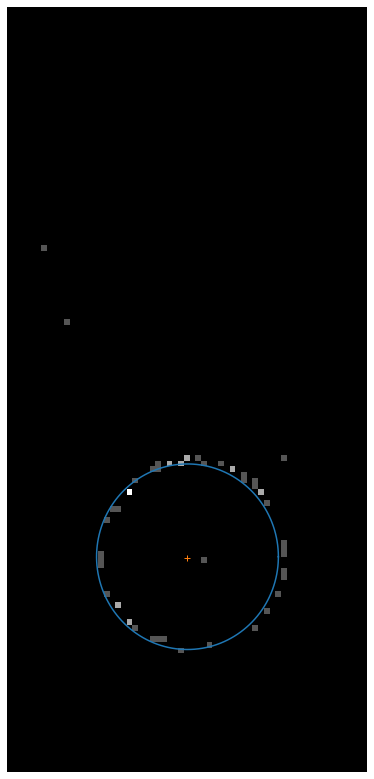

In [19]:
t = np.linspace(0, 2*np.pi, 300)
xx, yy = XY(t, m.np_values())
#xx, yy = XY(t, np.array([ax0, ax1, bx1, ay0, ay1, by1]))

H = dp.X[loc_ind].toarray()
xedges = np.linspace(0, H.shape[0], H.shape[0])
yedges = np.linspace(0, H.shape[1], H.shape[1])
fig = plt.figure(frameon=False, figsize=(5, 5) )
ax = plt.Axes(fig, [0., 0., 1., H.shape[1]/H.shape[0]])
ax.set_axis_off()
fig.add_axes(ax)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H.T, cmap='gray')
plt.plot(xx, yy)
#xv, yv = ax0, ay0
plt.plot(xv, yv, '+')

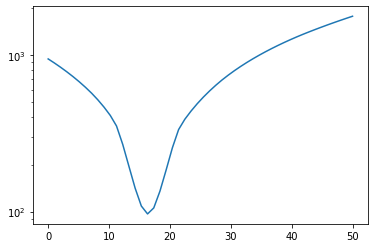

In [20]:
rr = np.linspace( 0, 50, 50)
#ax0, ax1, bx1, ay0, ay1, by1, w0, w1
#xv = 32
#yv = 37
#rs = [least_func(xv, r, 0, yv, 0, r) for r in rr]
rs = [Energy_function(xv, r, 0, yv, 0, r) for r in rr]
plt.plot(rr, rs)
plt.yscale('log')

## Посмотрим на время вычисления и на метрики

In [21]:
%timeit m.migrad()

The slowest run took 4.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.08 ms per loop


In [22]:
%%time
m = Minuit(Energy_function, pedantic=False, ax0=30, ax1=15, bx1=0, ay0=50, ay1=0, by1=5, limit_ax0=[0,63], limit_ay0=[0,135])
m.migrad()

CPU times: user 17.8 ms, sys: 3.93 ms, total: 21.7 ms
Wall time: 21.1 ms


In [45]:
H_all, h_all, mask_all = dp.generate_boards(board_size=100, N_circles=1, N_boards=1000)

0


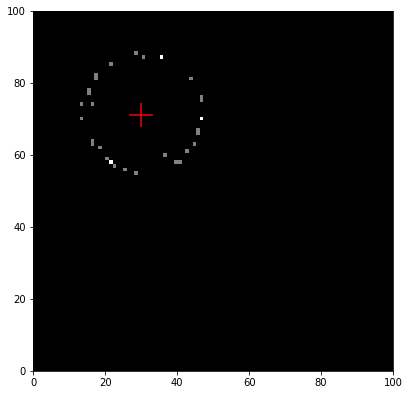

In [46]:
print_board(H_all[0], h_all[0])

In [0]:
def iou_score(m, h, H):
    # now only for circles
    ax0, ax1, bx1, ay0, ay1, by1 = m.np_values()
    xx = np.linspace(0, H.shape[0], H.shape[0])
    yy = np.linspace(0, H.shape[1], H.shape[1]).reshape((-1, 1))
    mask_minuit = ((xx-ax0)**2)/(ax1**2) + ((yy-ay0)**2)/(by1**2) <= 1 
    mask_sim = np.array([])
    for i in range(h.shape[0]):
        xv, yv, rv = h[i]
        circle = (xx - yv)**2 + (yy - xv)**2 <= rv**2
        mask_sim = np.append(mask_sim, circle)
    mask_sim = mask_sim.reshape((-1, H.shape[0], H.shape[1]))
    masks_minuit = np.broadcast_to(mask_minuit, mask_sim.shape)
    inter = np.logical_and(mask_sim, masks_minuit).sum(axis=(1,2))
    union = np.logical_or(mask_sim, masks_minuit).sum(axis=(1,2))
    return inter/union

In [0]:
rr = []
for index in range(1000):
    x = H_all[index].row
    y = H_all[index].col
    H = H_all[index].toarray()
    h = h_all[index]
    m = Minuit(Energy_function, pedantic=False, ax0=50, ax1=15, bx1=0, ay0=50, ay1=0, by1=15, limit_ax0=[0,99], limit_ay0=[0,99])
    m.migrad()
    rr.append( iou_score(m, h, H) )
    
rr = np.array( rr )

In [49]:
rr.mean()

0.9460239771634371

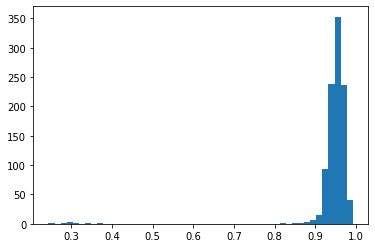

In [50]:
plt.hist(rr, 50);

### Посмотрим, что будет для нескольких кругов 

In [51]:
H_all, h_all, mask_all = dp.generate_boards(board_size=100, N_circles=2, N_boards=1000)

0


In [0]:
rr = []
for index in range(1000):
    x = H_all[index].row
    y = H_all[index].col
    H = H_all[index].toarray()
    #h = h_all[index][0].reshape(-1,3)
    h = h_all[index]
    m = Minuit(Energy_function, pedantic=False, ax0=50, ax1=15, bx1=0, ay0=50, ay1=0, by1=15, limit_ax0=[0,99], limit_ay0=[0,99])
    m.migrad()
    rr.append( max( iou_score(m, h, H) ) )
rr = np.array( rr )

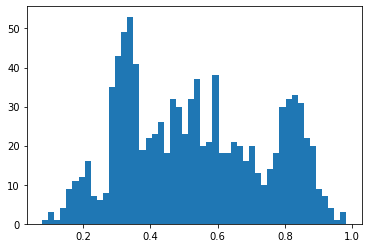

In [53]:
plt.hist(rr, 50);

In [54]:
%timeit m.migrad()

The slowest run took 7.58 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 775 µs per loop


In [55]:
%%time
m = Minuit(Energy_function, pedantic=False, ax0=50, ax1=15, bx1=0, ay0=50, ay1=0, by1=15, limit_ax0=[0,99], limit_ay0=[0,99])
m.migrad()

CPU times: user 17.8 ms, sys: 999 µs, total: 18.8 ms
Wall time: 19.6 ms


# Теперь сравним результат классического алгоритма и нейросети. Для этого построим распределение по IoU-скору для одинаковых картинок при фиксированному порогу нейросети (то есть тому порогу, которому мы бы хотели использовать в экспериментре)

In [0]:
import torch
import farichlib
from farichlib.Dataset import Dataset

In [57]:
my_dataset = Dataset(noise_level=(0,0))
my_dataset.load(dataset_path)

torch.Size([10000, 100, 100])


In [58]:
my_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'area': tensor([1239.0398,  948.6401,  948.6401]),
  'boxes': tensor([[48.4000, 11.4000, 83.6000, 46.6000],
          [14.6000, 33.6000, 45.4000, 64.4000],
          [30.6000, 32.6000, 61.4000, 63.4000]]),
  'image_id': tensor([0]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0.

In [0]:
import torchvision
import math
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model(load_trained=None):
    if load_trained is None:
        num_classes = 2
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        return model
    return torch.load(load_trained)

In [60]:
model = get_model(path_nn) #use pretrained model on noiseless data

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torchvision.models.detection.mask_rcnn.MaskRCNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torchvision.models.detection.transform.GeneralizedRCNNTransform' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by access

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and person
num_classes = 2
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [0]:
from farichlib import utils
from farichlib.utils import show_nn_result

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


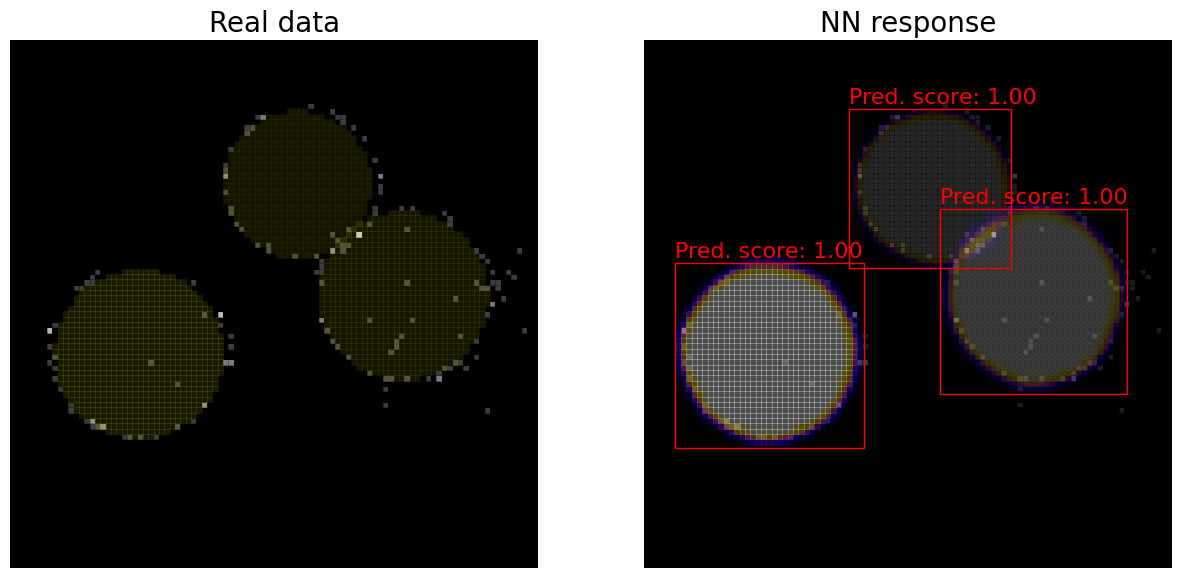

In [63]:
ind = random.randint(0, len(my_dataset)-1)
show_nn_result(model, my_dataset[ind], 0.99)

## Зафиксируем nn_thr на 0.9 и посмотрим распределение по iou_score

In [0]:
def iou_score2(mask1, masks2):
    masks1 = np.broadcast_to(mask1, masks2.shape)
    inter = np.logical_and(masks1, masks2).sum(axis=(1,2))
    union = np.logical_or(masks1, masks2).sum(axis=(1,2))
    return inter/union

In [0]:
def iou_imgage(dataset, index):
    img, bbox = dataset[index]
    masks1 = bbox['masks'][:].numpy().astype('bool')
    model.eval()
    prediction = model([img.to(device)])
    try:
        masks2 = (prediction[0]['masks'][:,0].cpu().detach().numpy() > 0.5).astype('bool')
        scores = prediction[0]['scores'].cpu().detach().numpy()
    except:
        return np.array([[]])
    rates = []
    for mask1 in masks1:
        rates.append(iou_score2(mask1, masks2))
    # appending scores to the end
    rates.append(scores)
    return rates

In [67]:
r = iou_imgage(dataset = my_dataset, index=0)
r

[array([0.01416431, 0.93294118, 0.        ]),
 array([0.19596542, 0.        , 0.94620253]),
 array([0.9514867 , 0.01602787, 0.17894737]),
 array([0.9999652 , 0.99994886, 0.9988978 ], dtype=float32)]

In [0]:
# сейчас будет долго 
n_images = 200
iou_thr = 0.8
r = [ iou_imgage(dataset=my_dataset, index=i) for i in range(0,n_images) ]
r = np.array(r)

In [0]:
rr1 = []
rr2 = []
for elem in r:
    elem = np.array(elem).reshape((len(elem),-1))
    #index = len(elem)-1 # 1 for 1 circle, 2 --- for 2, 3 --- for 3 circles
    arr = np.array( [elem[i] for i in range(len(elem)-1)] )
    iou_scores = [row*(row == np.max(row)) for row in arr]*(elem[-1] > 0.9) 
    index = len(elem)-1 # 1 for 1 circle, 2 --- for 2, 3 --- for 3 circles
    if index == 1:
        rr1.append(iou_scores[iou_scores > 0])
    elif index == 2:
        rr2.append(iou_scores[iou_scores > 0])

In [0]:
rr1, rr2 = np.array(rr1), np.array(rr2)

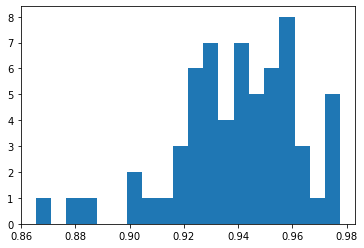

In [71]:
plt.hist(rr1, 20);

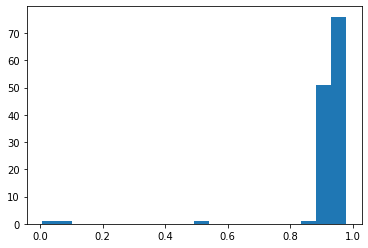

In [72]:
rr2_ = np.array([a for elem in rr2 for a in elem])
plt.hist(rr2_,20);

In [73]:
rr1.mean(), rr2_.mean()

(0.9395725303426485, 0.9165519146716431)